Daniel Lee

July 23, 2018

# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.graphics import utils
from matplotlib.lines import Line2D

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - n \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& n \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum{i=1}^N y_i = 0 \\
& n \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{n} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{n} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{n} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \sum_{i=1}^N x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2 \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x} - \hat{\beta}_1 x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [4]:
boston.data.shape

(506, 13)

In [5]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [6]:
# Print description of Boston housing data set
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Now let's explore the data set itself. 

In [7]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [8]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [9]:
print(boston.target.shape)

(506,)


In [10]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [11]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

Text(0.5,1,'Relationship between CRIM and Price')

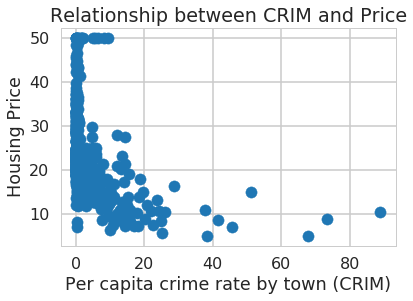

In [12]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

---

# Part 2 Checkup Exercise Set I

**1. What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?**

I see a negative relationship. That is, as `Per capita crime rate by town (CRIM)` increases, `Housing Price` increases. The relationship is non-linear. What's strange/interesting about the data is that the `Housing Price` has a maximum value at $50,000. 16 houses have this price. 

In [13]:
bos.PRICE[bos.PRICE == max(bos.PRICE)].shape

(16,)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


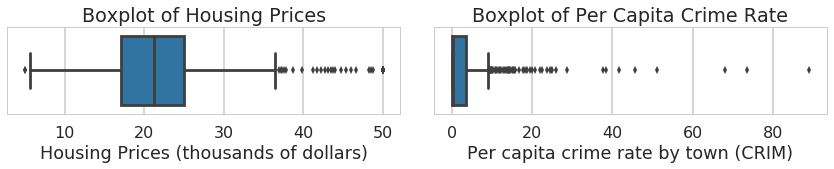

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 3))
_ = sns.boxplot(bos.PRICE, ax = ax1)
_ = ax1.set_xlabel('Housing Prices (thousands of dollars)')
_ = ax1.set_title('Boxplot of Housing Prices')
_ = sns.boxplot(bos.CRIM, ax = ax2)
_ = ax2.set_xlabel('Per capita crime rate by town (CRIM)')
_ = ax2.set_title('Boxplot of Per Capita Crime Rate')
fig.tight_layout(rect = [0, 0.03, 1, 0.85])
fig.show()

Based on the boxplots, I can see a handful of outliers for both `Housing Price` and `CRIM`.

**2. Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


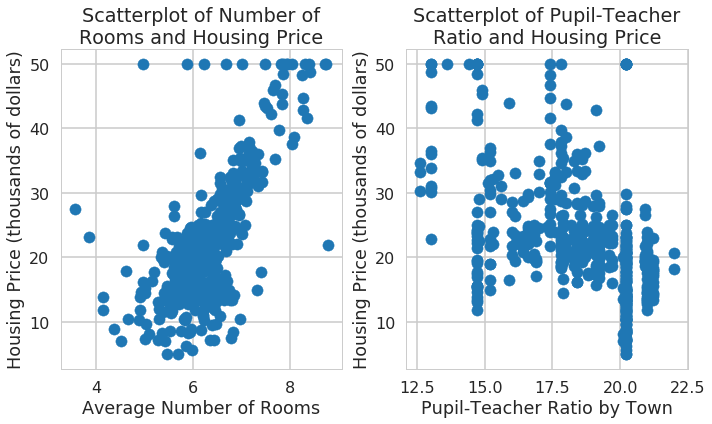

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
_ = ax1.scatter(bos.RM, bos.PRICE)
_ = ax1.set_xlabel('Average Number of Rooms')
_ = ax1.set_ylabel('Housing Price (thousands of dollars)')
_ = ax1.set_title('Scatterplot of Number of\nRooms and Housing Price')
_ = ax2.scatter(bos.PTRATIO, bos.PRICE)
_ = ax2.set_xlabel('Pupil-Teacher Ratio by Town')
_ = ax2.set_ylabel('Housing Price (thousands of dollars)')
_ = ax2.set_title('Scatterplot of Pupil-Teacher\nRatio and Housing Price')
fig.tight_layout()
fig.show()

**`Housing Price` vs `Average Number of Rooms`**: As average numer of rooms increase, housing price also increases. The relationship seems to be linear for the most part. However, there are some outliers at the extreme values where the relationship is no longer linear. There are a few houses that do not have many rooms but the price is pretty high. And then there are houses that have many rooms but the price is quite low. These points should be investigated further to see why this is the case.

**`Housing Price` vs `Pupil-Teacher Ratio by Town`**: As the pupil-teacher ratio by town increases, housing price decreases. However, the relationship does not seem to be very predictive. That is, given a pupil-teacher ratio, there's quite a bit of variation in terms of housing prices. The plot also indicates that many towns have the same number of pupil-teacher ratio by town.

**3. What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


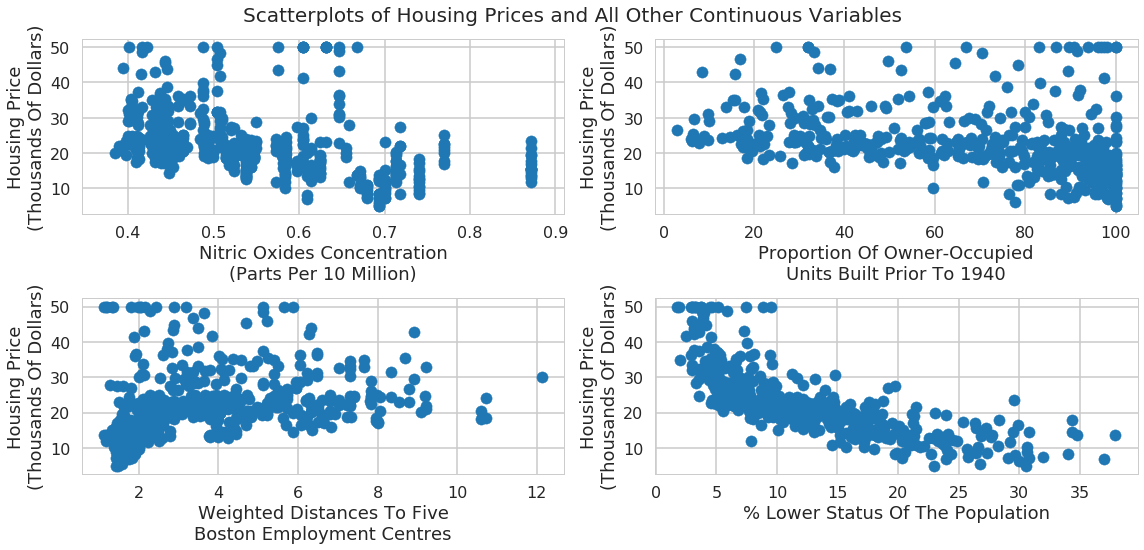

In [16]:
bos_interesting_columns = bos[['NOX', 'AGE', 'DIS', 'LSTAT', 'PRICE']]
bos_interesting_columns.columns = ['nitric oxides concentration\n(parts per 10 million)',
                               'proportion of owner-occupied\nunits built prior to 1940',
                               'weighted distances to five\nBoston employment centres',
                               '% lower status of the population',
                               'Housing Price\n(Thousands of dollars)']

bos_interesting_columns.columns = [column.title() for column in bos_interesting_columns]

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
for i, ax in enumerate(axes.flatten()):
    _ = ax.scatter(x = bos_interesting_columns.iloc[:, i], y = bos_interesting_columns.iloc[:, -1])
    _ = ax.set_ylabel(bos_interesting_columns.columns[-1], fontsize = 18)
    _ = ax.set_xlabel(bos_interesting_columns.columns[i], fontsize = 18)
fig.suptitle('Scatterplots of Housing Prices and All Other Continuous Variables', fontsize = 20)
fig.tight_layout(rect = [0, 0.03, 1, 0.95])
fig.show()

**`Nitric Oxides Concentration` vs `Housing Price`**: This is interesting because my initial thought is that pollution levels would affect housing prices. As the scatter plot shows, higher the pollution level, the lower the housing price. However, the relationship does not seem to be very strongly linear.

**`Proportion Of Owner-Occupied Units Built Prior To 1940` vs `Housing Price`**: This is interesting because I would imagine that older houses would be cheaper. The scatter plot shows this. Generally, older houses are cheaper. However, there's still a good amount of houses that are quite old and the house prices are still quite high. This relationship is nonlinear.

**`Weighted Distances To Five Boston Employment Centres` vs `Housing Price`**: This is interesting because I would imagine that the closer the houses are to employment centers, the cheaper the housing prices. However, this is not necessarily the case. There are quite a bit of houses that are cheaper because they are closer to employment centers. However, after a certain distance, the housing prices don't vary as much.

**`% Lower Status of the Population` vs `Housing Price`**: This is interesting because I would imagine that the higher the percentage of lower status, the lower the housing price. And this is indeed the case. However, the relationship is not linear. It seems to be more exponential.

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

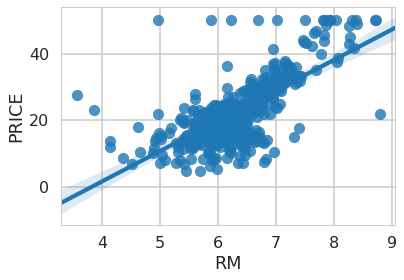

In [17]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)
plt.show()

### Histograms
***


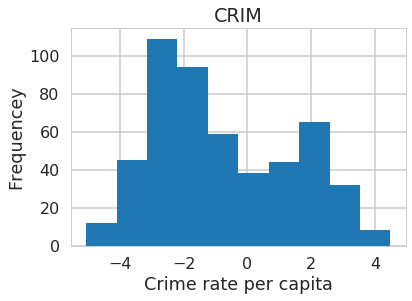

In [18]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequencey")
plt.show()

***
# Part 2 Checkup Exercise Set II

**1. In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


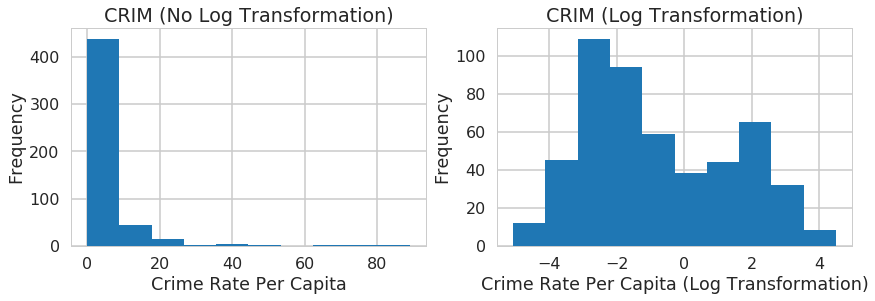

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))

_ = ax1.hist(bos.CRIM)
_ = ax1.set_title('CRIM (No Log Transformation)')
_ = ax1.set_xlabel('Crime Rate Per Capita')
_ = ax1.set_ylabel('Frequency')
_ = ax2.hist(np.log(bos.CRIM))
_ = ax2.set_title('CRIM (Log Transformation)')
_ = ax2.set_xlabel('Crime Rate Per Capita (Log Transformation)')
_ = ax2.set_ylabel('Frequency')
fig.show()

One common purpose of taking the log transformation is to make highly skewed distributions less skewed. It does this because the log transformation spreads out data points that are close to each other. At the same time, the log transformation also reduces the distance between the data points that are far apart from each other. That is why we see the range of the log transformation is a lot smaller than the range of the data that did not undergo log transformation. Further, we see that the log transformation distributed the data points evenly, whereas the raw data points have a high concentration of data points at every small values.

By taking the log, we see that the highly right-skewed distribution has become a more bimodal distribution.

**2. Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


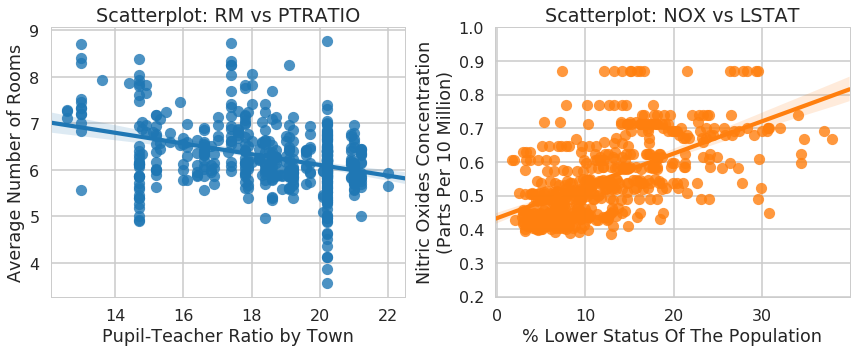

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
_ = sns.regplot(y = "RM", x = "PTRATIO", data = bos, ax = ax1)
_ = ax1.set_xlabel('Pupil-Teacher Ratio by Town')
_ = ax1.set_ylabel('Average Number of Rooms')
_ = ax1.set_title('Scatterplot: RM vs PTRATIO')
_ = sns.regplot(y = 'NOX', x = 'LSTAT', data = bos, ax = ax2)
_ = ax2.set_xlabel('% lower status of the population'.title())
_ = ax2.set_ylabel('nitric oxides concentration\n(parts per 10 million)'.title())
_ = ax2.set_title('Scatterplot: NOX vs LSTAT')
_ = ax2.set_ylim((0.2, 1))
fig.tight_layout()
fig.show()

From the scatterplots, I see that there's some level of correlation between `RM` and `PTRATIO` as well as between `NOX` and `LSTAT`. This indicates that there's some level of collinearity among the predictors.

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [21]:
# Import regression modules
import statsmodels.api as sm

In [22]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           2.49e-74
Time:                        02:06:26   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

# Part 3 Checkup Exercise Set I
***

**1. Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.**

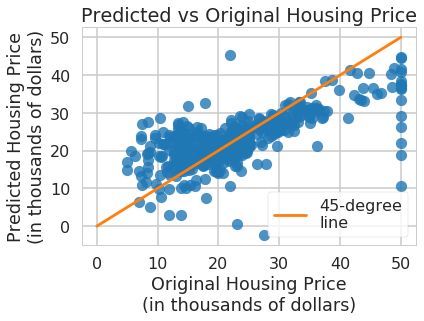

In [23]:
_ = sns.regplot(y = m.fittedvalues, x = bos.PRICE, fit_reg = False)
_ = plt.ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = plt.xlabel('Original Housing Price\n(in thousands of dollars)')
_ = plt.title('Predicted vs Original Housing Price')
_ = plt.plot([0, 50], [0, 50]) # 45 degree line
_ = plt.legend(['45-degree\nline'], frameon = True)
plt.show()

All the points below the 45-degree line are under-predictions and all the points above it are over-predictions. I see that for the most part, the points are close to the 45-degree line. However, there are a handful of points where the predictions are very different than the original price. One of the predictions have a negative value, which doesn't make sense. Also, all the houses that have price at $50,000 have lower predicted values.

### Fitting Linear Regression using `sklearn`


In [24]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

In [25]:
lm.fit(X = X, y = bos.PRICE)
y_pred = lm.predict(X = X)
lm.score(X = X, y = bos.PRICE) # R^2 value

0.7406077428649428

#### What output can you get?

In [26]:
# Look inside lm object
# lm.<tab>

In [27]:
print('Estimated coefficients: {}\nEstimated intercept: {}'.format(lm.coef_, lm.intercept_))

Estimated coefficients: [-1.07170557e-01  4.63952195e-02  2.08602395e-02  2.68856140e+00
 -1.77957587e+01  3.80475246e+00  7.51061703e-04 -1.47575880e+00
  3.05655038e-01 -1.23293463e-02 -9.53463555e-01  9.39251272e-03
 -5.25466633e-01]
Estimated intercept: 36.49110328036135


Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [28]:
# Use all 13 predictors to fit linear regression model
lm.fit(X = X, y = bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

***
# Part 3 Checkup Exercise Set II

**1. How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).**

To remove the intercept using `statsmodels`, run the following code:

In [29]:
# fit the linear model using all the variables and remove intercept
all_columns = "+".join(bos.columns[:-1]) # string processing to create equation
my_formula = "PRICE~" + all_columns + '-1' # string processing to remove intercept
m_no_intercept = ols(formula=my_formula, data=bos).fit()
print(m_no_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     891.1
Date:                Wed, 25 Jul 2018   Prob (F-statistic):               0.00
Time:                        02:06:26   Log-Likelihood:                -1523.8
No. Observations:                 506   AIC:                             3074.
Df Residuals:                     493   BIC:                             3129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0916      0.034     -2.675      0.0

To remove the intercept using `sklearn`, run the following code.

In [30]:
# This creates a LinearRegression object without intercept
lm_no_intercept = LinearRegression(fit_intercept = False)
lm_no_intercept.fit(X = X, y = bos.PRICE)
print('Estimated coefficients: {}\nEstimated intercept: {}'.format(lm_no_intercept.coef_, lm_no_intercept.intercept_))

Estimated coefficients: [-9.16297843e-02  4.86751203e-02 -3.77930006e-03  2.85636751e+00
 -2.88077933e+00  5.92521432e+00 -7.22447929e-03 -9.67995240e-01
  1.70443393e-01 -9.38925373e-03 -3.92425680e-01  1.49832102e-02
 -4.16972624e-01]
Estimated intercept: 0.0


For this particular data, I would recommend to have an intercept because it seems to makes more sense that way. For example, if a house has zero rooms, it should still have a default house price. If the percent of lower status of the population is zero, the house should still have a default house price. If the house exists, there should be a default price for the house. One note is that it wouldn't make sense that the weighted distances to five Boston employment centers would be zero for a given house. So, it would be impossible for the weighted distances to five Boston employment centers would be zero.

**2. One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.**

I would think that normality of residuals is not enough to prove that residuals are i.i.d. but am not sure about this. 

Even if the residuals are not normally distributed, that does not necessarily mean that the residuals are i.i.d. This can just mean that the residuals are i.i.d. but the distribution is not normal.

If the residuals are normally distributed, this also does not mean that the residuals are i.i.d. This is because residuals can technically come from different distributions. And when these distributions combine, they can look like a normal distribution. 

One way to test for independence is to create scatter plots between the residuals and all other predictor variables. If there's a distinct pattern, then the independence assumption is violated. 

One way to test for identical distribution is to check for homoscedascity. If the variance seems to be changing with the fitted y-values or any of the predictor variables, then it suggests the residuals have different variances for different predictor/fitted-y values. This suggests that the residuals are not coming from identical distributions.

A sure way of testing for i.i.d. is to know the sampling procedure and the experiment design.

**3. True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.**

False. To use linear regression, $Y$ does not have to be normally distributed. The assumption is that the errors, $\epsilon$, are normally distributed. Then, by the linear model:

$$Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 

This means that $Y$ is also normally distributed, because linear combination of normal distributions are also normally distributed and the $X_i$s are assumed to be constants.

However, this assumption of $\epsilon$ being normally distributed is only important when doing hypothesis tests and constructing confidence intervals. To estimate $\beta_i$s does not require normality assumption. When we want to perform statistical inference by using the t distribution to determine statistical significance, then we assume normality. However, for this also, if we have sufficiently large sample size, by the CLT, the $\beta_i$s will be approximately normally distributed. Hence, we can still construct confidence intervals and calculate p-values by assuming normal distribution.

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [31]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.49110328036135


In [32]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [33]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [34]:
# first five predicted prices
y_pred_sklearn_lm = lm.predict(X)
y_pred_sklearn_lm[0:5]

array([30.00821269, 25.0298606 , 30.5702317 , 28.60814055, 27.94288232])

***
# Part 3 Checkup Exercise Set III

**1. Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


count    506.000000
mean      22.532806
std        7.914896
min       -4.283009
25%       17.447270
50%       22.120625
75%       27.412587
max       44.673399
dtype: float64

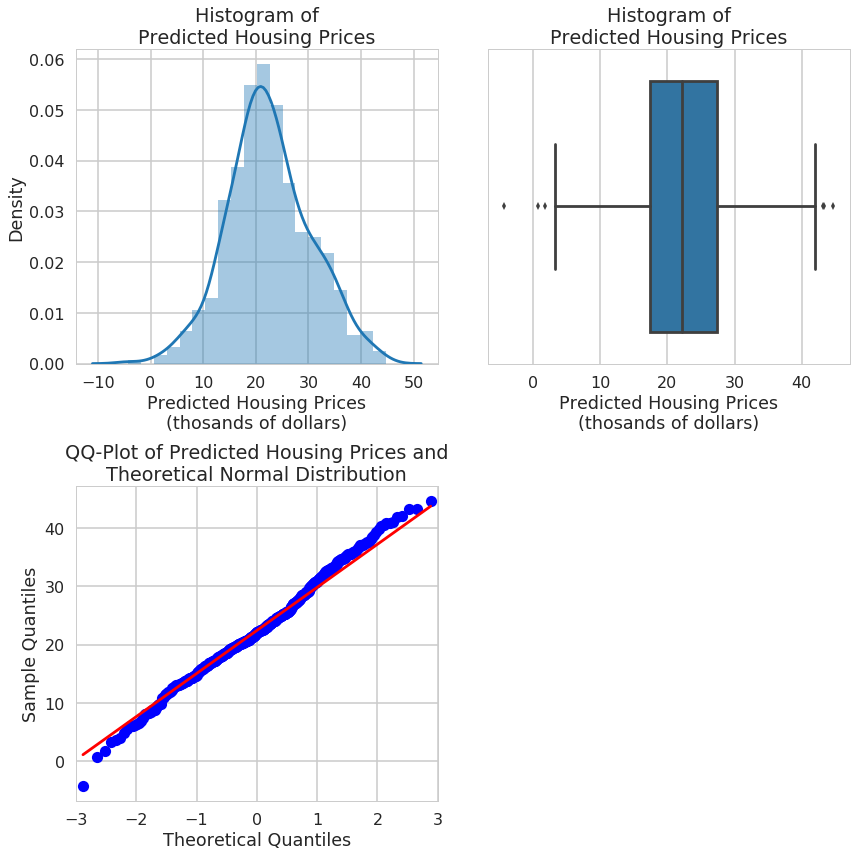

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
flattened_axes = axes.flatten()
_ = sns.distplot(y_pred_sklearn_lm, ax = flattened_axes[0])
_ = flattened_axes[0].set_title('Histogram of\nPredicted Housing Prices')
_ = flattened_axes[0].set_xlabel('Predicted Housing Prices\n(thosands of dollars)')
_ = flattened_axes[0].set_ylabel('Density')
_ = sns.boxplot(y_pred_sklearn_lm, ax = flattened_axes[1])
_ = flattened_axes[1].set_title('Histogram of\nPredicted Housing Prices')
_ = flattened_axes[1].set_xlabel('Predicted Housing Prices\n(thosands of dollars)')
_ = sm.qqplot(y_pred_sklearn_lm, line = 'q', ax = flattened_axes[2])
_ = flattened_axes[2].set_title('QQ-Plot of Predicted Housing Prices and\nTheoretical Normal Distribution')
_ = flattened_axes[3].set_yticklabels('')
_ = flattened_axes[3].set_xticklabels('')
_ = flattened_axes[3].grid(False)
_ = flattened_axes[3].axis('off')
fig.tight_layout()
fig.show()
pd.Series(y_pred_sklearn_lm).describe()

There are 506 predicted values. The mean is \$22,533. The standard deviation is \$7,915. The median is \$22,121. The minimum value is -\$4,283. The maximum is \$44,673. The interquartile range is \$9,965. The shape is approximately a normal distribution.

There are outliers in the predicted values. The outliers are clear because these values don't make much sense. For instance, one value is predicted to be -\$4,283. Another house is predicted to be \$780. What we can do is to investigate further to see why this might be. Perhaps there was a typo in the predictor variables that are causing this to happen. Or, perhaps these values don't differ much from the true housing price values, in which case we should keep these outliers. 

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

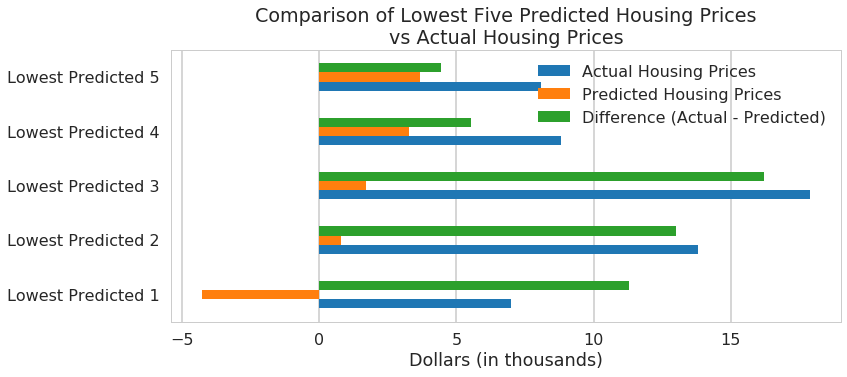

In [36]:
# take a look at the lowest five predicted values and compare them to the X and actual housing price
low_five = pd.Series(y_pred_sklearn_lm).sort_values().head().reset_index()
low_five_df = X.iloc[low_five['index'], :]
low_five_df['PRICE'] = bos.iloc[low_five['index'], bos.columns.get_loc('PRICE')]
low_five_df['predicted_price'] = list(low_five.iloc[:, 1])
low_five_df['difference'] = low_five_df['PRICE'] - low_five_df['predicted_price']
low_five_df.reset_index(inplace = True)

# side-by-side bar plot of predicted housing prices vs actual housing prices
fig, ax = plt.subplots(figsize = (12, 5))
_ = low_five_df.plot(x = 'index', y = low_five_df.columns[-3:], kind = 'barh', ax = ax)
ax.set_title('Comparison of Lowest Five Predicted Housing Prices\nvs Actual Housing Prices')
ax.set_xlabel('Dollars (in thousands)')
ax.set_ylabel('')
ax.set_yticklabels(['Lowest Predicted 1', 'Lowest Predicted 2', 'Lowest Predicted 3', 'Lowest Predicted 4', 'Lowest Predicted 5'])
ax.legend(['Actual Housing Prices', 'Predicted Housing Prices', 'Difference (Actual - Predicted)'])
ax.grid(b = False, axis = 'y') # turn off horizontal grid lines
fig.show()

From the barplot above, I can see that the predicted price does not differ much from the actual housing price. So, it seems as though the linear regression model is working as it's supposed to. The only thing we should adjust is that if the prices are predicted to be negative values, we should change them to a baseline price (e.g. the minimum housing price among the actual housing prices), because negative housing values don't make sense.

**2. Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before)**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


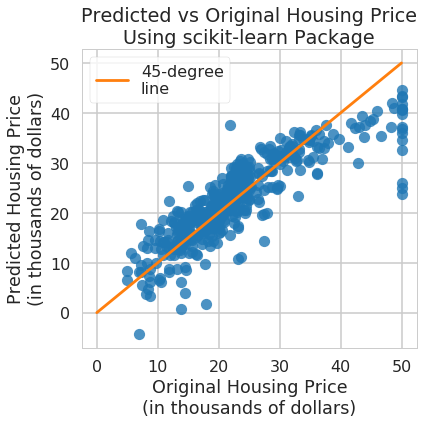

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = sns.regplot(y = y_pred_sklearn_lm, x = bos.PRICE, fit_reg = False, ax = ax)
_ = ax.set_ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = ax.set_xlabel('Original Housing Price\n(in thousands of dollars)')
_ = ax.set_title('Predicted vs Original Housing Price\nUsing scikit-learn Package')
_ = ax.plot([0, 50], [0, 50]) # 45 degree line
_ = ax.legend(['45-degree\nline'], frameon = True)
fig.tight_layout()
fig.show()

All the points below the 45-degree line are under-predictions and all the points above it are over-predictions. I see that for the most part, the points are close to the 45-degree line. However, there are a handful of points where the predictions are very different than the original price. One of the predictions have a negative value, which doesn't make sense. Also, all the houses that have price at $50,000 have lower predicted values.

**3. We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?**

Based on exploring the two packages, `statsmodels` has an advantage in that it generates output in a convenient way. It generates a comprehensive report of the linear model using the `summary()` method. The `scikit-learn` linear regression model works too but it's a little more difficult to access all the necessary results. The advantage of `scikit-learn` is that it has the same model structure as all the other machine learning algorithms. Hence, it's easier to remember how to use.

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [38]:
print(np.sum((bos.PRICE - y_pred_sklearn_lm) ** 2))

11080.276284149873


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [39]:
print(np.sum(y_pred_sklearn_lm - np.mean(bos.PRICE)) ** 2)

9.11966625339713e-23


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables (not including the intercept), $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{ESS}{K}$$
$$MSR = \frac{RSS}{N-K-1}$$

**Remember: ** Notation may vary across resources particularly the use of *R* and *E* in *RSS/ESS* and *MSR/MSE*. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i \neq 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K - 1$ and $K$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

# Part 3 Checkup Exercise Set IV
***

Let's look at the relationship between `PTRATIO` and housing price.

**1. Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.**

I will fit the model using both `statsmodels` and `scikit-learn` packages

In [40]:
# using statsmodel
m_ptratio_price = ols('PRICE ~ PTRATIO',bos).fit()
m_ptratio_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           1.61e-34
Time:                        02:06:29   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.000      56.393      68.296
PTRATIO       -2.1572      0.163    -13.233      0.000      -2.477      -1.837
==============================================================================
Omnibus:                       92.924   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.444
Skew:                           1.001   Prob(JB):                     2.68e-42
Kurtosis:                       5.252   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# using scikit-learn
# reshape the data
X_ptratio = bos.PTRATIO.values.reshape(-1, 1)

# This creates a LinearRegression object
lm_ptratio = LinearRegression()

lm_ptratio.fit(X = X_ptratio, y = bos.PRICE)
print('Estimated coefficient: {}\nEstimated intercept: {}'.format(lm_ptratio.coef_[0], lm_ptratio.intercept_))

Estimated coefficient: -2.1571752960609647
Estimated intercept: 62.34462747483265


Based on the estimates, the estimated intercept $\hat{\beta_0} = 62.345$. This means that if `PTRATIO` is zero, the predicted housing price is \$62,345. The estimated coefficient $\hat{\beta_1} = -2.157$. This means that if `PTRATIO` increases by one unit, the predicted housing price will decrease by -\$2,157.

**2. Calculate (or extract) the $R^2$ value. What does it tell you?**

In [42]:
r2_scikit_learn = lm_ptratio.score(X = X_ptratio, y = bos.PRICE)
print('R^2 from statsmodels: {}\nR^2 from scikit-learn: {}'.format(m_ptratio_price.rsquared, r2_scikit_learn))

R^2 from statsmodels: 0.257847318009223
R^2 from scikit-learn: 0.257847318009223


The $R^2$ value is 0.258. This tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model is 25.8%. The linear regression model is the following:

$$Y_i = \hat{\beta_0} + \hat{\beta_1}* X + e_i$$

where $\hat{\beta_1}$ is the coefficient representing PTRATIO and $e_i$ is the $i$th residual.

**3. Compute the $F$-statistic. What does it tell you?**

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$


In [43]:
N = len(bos.PRICE) # sample size; number of observations
K = 1 # number of variables, not including the intercept
f_scikit_learn = (r2_scikit_learn / (1 - r2_scikit_learn)) * ((N - K - 1)/K)
print('F-Statistic from statsmodels: {}\nF-Statistic from scikit-learn: {}'.format(m_ptratio_price.fvalue, f_scikit_learn))

F-Statistic from statsmodels: 175.1055428756955
F-Statistic from scikit-learn: 175.10554287569548


In [44]:
import scipy.stats
DFN = K
DFD = N - K - 1
p_value_f_scikit_learn = scipy.stats.f.sf(x = f_scikit_learn, dfn=DFN, dfd=DFD)
print('F test p-value from statsmodels: {}\nF test p-value from scikit-learn: {}'.format(m_ptratio_price.f_pvalue,\
                                                                                         p_value_f_scikit_learn))

F test p-value from statsmodels: 1.6095094784729786e-34
F test p-value from scikit-learn: 1.6095094784729786e-34


F-statistic is 175.1055 with degrees of freedom 1 and 504. The p-values, 1.6095 * 10^(-34), are very small. I would reject the following null hypothesis at significance level 0.05:

$$H_0: \beta_1 = 0$$

It seems as though $\beta_1 \neq 0$. The linear model

$$Y_i = \hat{\beta}_0 + \hat{\beta_1}X_1 + e_i$$ 

seems to fit the data better than the intercept only model

$$Y_i = \hat{\beta}_0 + e_i$$

**4. Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.**

In [45]:
print('''t-statistic for regression coefficient for PTRATIO: {}
t-statistic squared for regression coef for PTRATIO: {}
F-statistic for overall regression model: {}'''.format(m_ptratio_price.tvalues[1],\
                                                       m_ptratio_price.tvalues[1]**2,\
                                                       m_ptratio_price.fvalue))

t-statistic for regression coefficient for PTRATIO: -13.232745099777881
t-statistic squared for regression coef for PTRATIO: 175.10554287569553
F-statistic for overall regression model: 175.1055428756955


I notice that the squared value for regression coefficient PTRATIO t-statistic is equal to the F-statistic.

***
# Part 3 Checkup Exercise Set V

**Fit a linear regression model using three independent variables**

* 'CRIM' (per capita crime rate by town)
* 'RM' (average number of rooms per dwelling)
* 'PTRATIO' (pupil-teacher ratio by town)

In [46]:
# using statsmodels
m_crim_rm_ptratio_price = ols('PRICE ~ CRIM + RM + PTRATIO',bos).fit()
m_crim_rm_ptratio_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     244.2
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           1.09e-97
Time:                        02:06:29   Log-Likelihood:                -1612.6
No. Observations:                 506   AIC:                             3233.
Df Residuals:                     502   BIC:                             3250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3066      4.038     -0.819      0.413     -11.240       4.627
CRIM          -0.2021      0.032     -6.301      0.000      -0.265      -0.139
RM             7.3816      0.402     18.360      0.000       6.592       8.171
PTRATIO       -1.0742      0.133     -8.081      0.000      -1.335      -0.813
==============================================================================
Omnibus:                      233.249   Durbin-Watson:                   0.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2002.374
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                      12.054   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# using scikit-learn
# reshape the data
X_crim_rm_ptratio = bos.loc[:, ['CRIM', 'RM', 'PTRATIO']]

# This creates a LinearRegression object
lm_crim_rm_ptratio = LinearRegression()

lm_crim_rm_ptratio.fit(X =X_crim_rm_ptratio, y = bos.PRICE)
print('Estimated coefficients: {}\nEstimated intercept: {}'.format(lm_crim_rm_ptratio.coef_, lm_crim_rm_ptratio.intercept_))

Estimated coefficients: [-0.20210971  7.3815667  -1.0741868 ]
Estimated intercept: -3.3066171324064797


**1. Compute or extract the $F$-statistic. What does it tell you about the model?**

In [48]:
r2_scikit_learn_part_3_5 = lm_crim_rm_ptratio.score(X = X_crim_rm_ptratio, y = bos.PRICE)

K_part_3_5 = 3 # number of variables, not including the intercept
f_scikit_learn_part_3_5 = (r2_scikit_learn_part_3_5 / (1 - r2_scikit_learn_part_3_5)) * ((N - K_part_3_5 - 1)/K_part_3_5)
print('F-Statistic from statsmodels: {}\nF-Statistic from scikit-learn: {}'.format(m_crim_rm_ptratio_price.fvalue,\
                                                                                   f_scikit_learn_part_3_5))

F-Statistic from statsmodels: 244.22387023858764
F-Statistic from scikit-learn: 244.22387023858766


In [49]:
DFN = K_part_3_5
DFD = N - K_part_3_5 - 1
p_value_f_scikit_learn_part_3_5 = scipy.stats.f.sf(x = f_scikit_learn_part_3_5, dfn=DFN, dfd=DFD)
print('F test p-value from statsmodels: {}\nF-Statistic from scikit-learn: {}'.format(m_crim_rm_ptratio_price.f_pvalue,\
                                                                                      p_value_f_scikit_learn_part_3_5))

F test p-value from statsmodels: 1.0899937674844589e-97
F-Statistic from scikit-learn: 1.0899937674843969e-97


The F-statistic is 244.22 with degrees of freedom 3 and 502. The p-value for this F-test is 1.09 * 10^(-97). This means that I will reject the following null hypothesis at significance level 0.05:

$$H_0: \beta_i = 0, \mbox{for $i = {1, 2, 3}$}$$

It seems as though at least one of the $\beta_i$s are not equal to zero. The linear model

$$Y_i = \hat{\beta}_0 + \hat{\beta_1}X_1 + \hat{\beta_2}X_2 + \hat{\beta_3}X_3 + e_i$$ 

seems to fit the data better than the intercept only model

$$Y_i = \hat{\beta}_0 + e_i$$

**2. Compute or extract the $R^2$ statistic. What does it tell you about the model?**

In [50]:
r2_scikit_learn_part_3_5 = lm_crim_rm_ptratio.score(X = X_crim_rm_ptratio, y = bos.PRICE)
print('R^2 from statsmodels: {}\nR^2 from scikit-learn: {}'.format(m_crim_rm_ptratio_price.rsquared, r2_scikit_learn_part_3_5))

R^2 from statsmodels: 0.5934141551136979
R^2 from scikit-learn: 0.5934141551136979


The $R^2$ value is 0.593. This tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model is 59.3%. The linear regression model is the following:

$$Y_i = \hat{\beta}_0 + \hat{\beta_1}X_1 + \hat{\beta_2}X_2 + \hat{\beta_3}X_3 + e_i$$ 

where 

* $\hat{\beta_1}$ is the coefficient representing `CRIM`
* $\hat{\beta_2}$ is the coefficient representing `RM`
* $\hat{\beta_3}$ is the coefficient representing `PTRATIO`

and $e_i$ is the $i$th residual.

**3. Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.**

In [51]:
m_short_summary = pd.DataFrame({'tvalues': m_crim_rm_ptratio_price.tvalues, 'pvalues': m_crim_rm_ptratio_price.pvalues})
m_short_summary

,tvalues,pvalues
Intercept,-0.818840,4.132660e-01
CRIM,-6.301420,6.458141e-10
RM,18.360300,5.590314e-58
PTRATIO,-8.081087,4.822612e-15


Based on the p-values for the t-test from the output given using `statsmodels` above, I see that all the variables except the intercept are statistically significant. This suggests the following:

* As `CRIM` increases by one unit, `PRICE` decreases by \$6,301.  
* As `RM` increases by one unit, `PRICE` increases by \$18,360.
* As `PTRATIO` increases by one unit, `PRICE` decreases by \$8,081.

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

***
# Part 4 Checkup Exercises

**1. Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?**

I will add variables `NOX` and `LSTAT` to the model from part 3. That is, now my model will be the following:

$$Y_i = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \epsilon_i$$ 

where 

* $\beta_1$ is the coefficient representing `CRIM`
* $\beta_2$ is the coefficient representing `RM`
* $\beta_3$ is the coefficient representing `PTRATIO`
* $\beta_4$ is the coefficient representing `NOX`
* $\beta_5$ is the coefficient representing `LSTAT`

and $\epsilon_i$ is the $i$th residual.

In [52]:
# using statsmodels
m_crim_rm_ptratio_nox_lstat_price = ols('PRICE ~ CRIM + RM + PTRATIO + NOX + LSTAT',bos).fit()
m_crim_rm_ptratio_nox_lstat_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     214.0
Date:                Wed, 25 Jul 2018   Prob (F-statistic):          9.68e-122
Time:                        02:06:29   Log-Likelihood:                -1550.7
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.5508      4.112      4.268      0.000       9.472      25.630
CRIM          -0.0605      0.031     -1.922      0.055      -0.122       0.001
RM             4.6279      0.428     10.805      0.000       3.786       5.469
PTRATIO       -0.8948      0.119     -7.511      0.000      -1.129      -0.661
NOX           -1.3536      2.552     -0.530      0.596      -6.367       3.660
LSTAT         -0.5232      0.051    -10.208      0.000      -0.624      -0.422
==============================================================================
Omnibus:                      223.920   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1276.962
Skew:                           1.871   Prob(JB):                    5.14e-278
Kurtosis:                       9.824   Cond. No.                         439.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# F-test comparison between nested model and full model using statsmodels compare_f_test method
m_crim_rm_ptratio_nox_lstat_price.compare_f_test(m_crim_rm_ptratio_price)

(69.19798186586492, 2.9509914726948665e-27, 2.0)

In [54]:
# F-test comparison between nested model and full model using statsmodels anova_lm function
from statsmodels.stats.anova import anova_lm

m01 = ols('PRICE ~ CRIM + RM + PTRATIO', data=bos).fit()
m02 = ols('PRICE ~ CRIM + RM + PTRATIO + NOX + LSTAT', data=bos).fit()
anovaResults = anova_lm(m01, m02)
print(anovaResults)

   df_resid           ssr  df_diff      ss_diff          F        Pr(>F)
0     502.0  17367.841062      0.0          NaN        NaN           NaN
1     500.0  13602.718413      2.0  3765.122648  69.197982  2.950991e-27


/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/root/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [55]:
# AIC comparison between restricted model and full model
print('AIC for restricted model: {}\nAIC for full model: {}'.\
      format(m_crim_rm_ptratio_price.aic, m_crim_rm_ptratio_nox_lstat_price.aic))

AIC for restricted model: 3233.1002744570037
AIC for full model: 3113.4588580966656


As a reminder, the **restricted model** or the **nested model** is the following:

$$Y_i = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \epsilon_i$$ 

where 

* $\beta_1$ is the coefficient representing `CRIM`
* $\beta_2$ is the coefficient representing `RM`
* $\beta_3$ is the coefficient representing `PTRATIO`

and $\epsilon_i$ is the $i$th residual.

And the **full model** is the following:

$$Y_i = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \epsilon_i$$ 

where 

* $\beta_1$ is the coefficient representing `CRIM`
* $\beta_2$ is the coefficient representing `RM`
* $\beta_3$ is the coefficient representing `PTRATIO`
* $\beta_4$ is the coefficient representing `NOX`
* $\beta_5$ is the coefficient representing `LSTAT`

and $\epsilon_i$ is the $i$th residual.

Here, we see that the full model fits the data better than the restricted model. Based on the F-test, we see a p-value of 2.95e-27, which means we reject the null hypothesis that the restricted model fits the data just as well as the full model.

Also, based on the AIC values, the restricted model has AIC of 3233, whereas the full model has AIC of 3113. Since the full model has the lower AIC, it suggests that **the full model fits the data better than the restricted model**.


## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


# Part 5 Checkup Exercises

<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

**Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.**

**1. Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?**

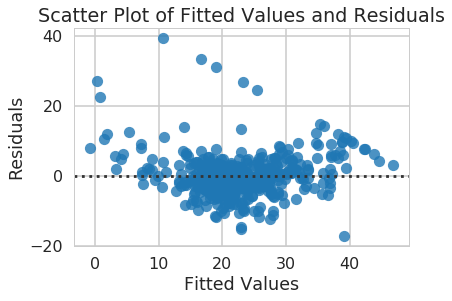

In [56]:
_ = sns.residplot(x = m_crim_rm_ptratio_price.fittedvalues, y = m_crim_rm_ptratio_price.resid)
_ = plt.xlabel('Fitted Values')
_ = plt.ylabel('Residuals')
_ = plt.title('Scatter Plot of Fitted Values and Residuals')

The plot above seems to have a slight curve (concave up/convex). There also seems to be quite a few outliers. The existence of a pattern (though slight) suggests that the distribution of the residuals do not follow a normal distribution. If the distribution of the residuals were normal, we would see a random scatter of points across all fitted values.

**2. Construct a quantile plot of the residuals. What does the plot tell you?**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


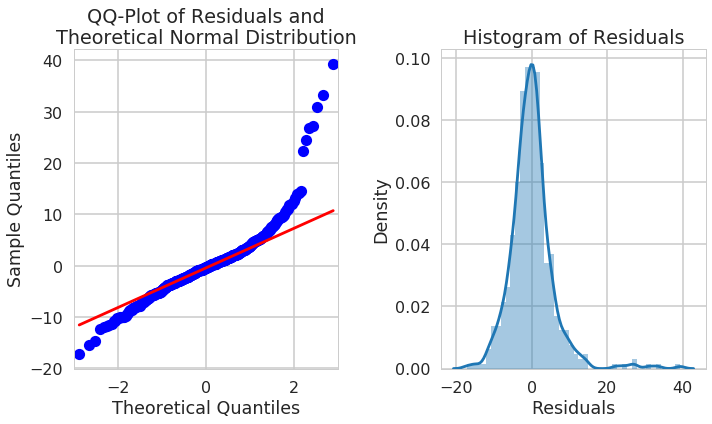

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
_ = sm.qqplot(m_crim_rm_ptratio_price.resid, line = 'q', ax = ax1)
_ = ax1.set_title('QQ-Plot of Residuals and\nTheoretical Normal Distribution')
_ = sns.distplot(m_crim_rm_ptratio_price.resid, norm_hist = True, ax = ax2)
_ = ax2.set_title('Histogram of Residuals')
_ = ax2.set_ylabel('Density')
_ = ax2.set_xlabel('Residuals')
fig.tight_layout()
fig.show()

The qq-plot above indicates that the distribution of the residuals have a long right tail (skewed right). This is verified by the histogram. According to the qq-plot, the distribution of the residuals also has a slightly longer left tail than a normal distribution. So I would conclude that the distribution of the residuals does not seem to be a normal distribution.

**3. What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?**

**Fitted vs Residual Plot**:
* **Advantage(s)**:
    * Detect the presence of a pattern 
    * Detect outliers

* **Disadvantage(s)**:
    * Cannot detect skewness of data

**Quantile Plot**:
* **Advantage(s)**:
    * Detect skewness
    * Detect outliers
* **Disadvantage(s)**:
    * Cannot detect presence of a pattern

**4. Identify any outliers (if any) in your model and write a story describing what these outliers might represent.**

I will use the studentized residuals to find the outliers using the built-in `outlier_test()` method in `statsmodels`. I will identify the outliers as ones that have p-value lower than $\alpha/n$, where $\alpha = 0.05$ and $n = 506$ is the sample size (Bonferroni correction). For the t-test, we will use t-distribution with $n - p - 1 = 501$ degrees of freedom, where $n = 506$ is the sample size and $p = 4$ is the number of parameters to estimate, including the intercept.

In [58]:
# examine the studentized residuals and perform t-test and use bonferroni correction for multiple testing adjustment 
# to get the significance level (alpha / n)
n = len(bos.PRICE)
alpha = 0.05
outlier_test = m_crim_rm_ptratio_price.outlier_test()
studentized_outliers = outlier_test[outlier_test['bonf(p)'] < alpha/n]
studentized_outliers

,student_resid,unadj_p,bonf(p)
368,7.030058,6.791305e-12,3.436401e-09
371,5.425650,9.005087e-08,4.556574e-05
372,5.858542,8.466152e-09,4.283873e-06


/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


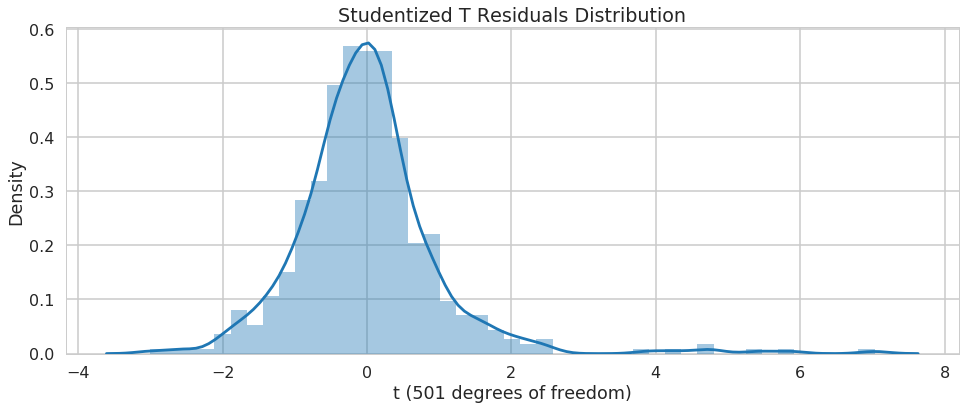

In [59]:
# plot the studentized residuals histogram
_ = plt.figure(figsize = (16, 6))
_ = sns.distplot(m_crim_rm_ptratio_price.outlier_test().student_resid, norm_hist = True)
_ = plt.title('Studentized T Residuals Distribution')
_ = plt.xlabel('t (501 degrees of freedom)')
_ = plt.ylabel('Density')
plt.show()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


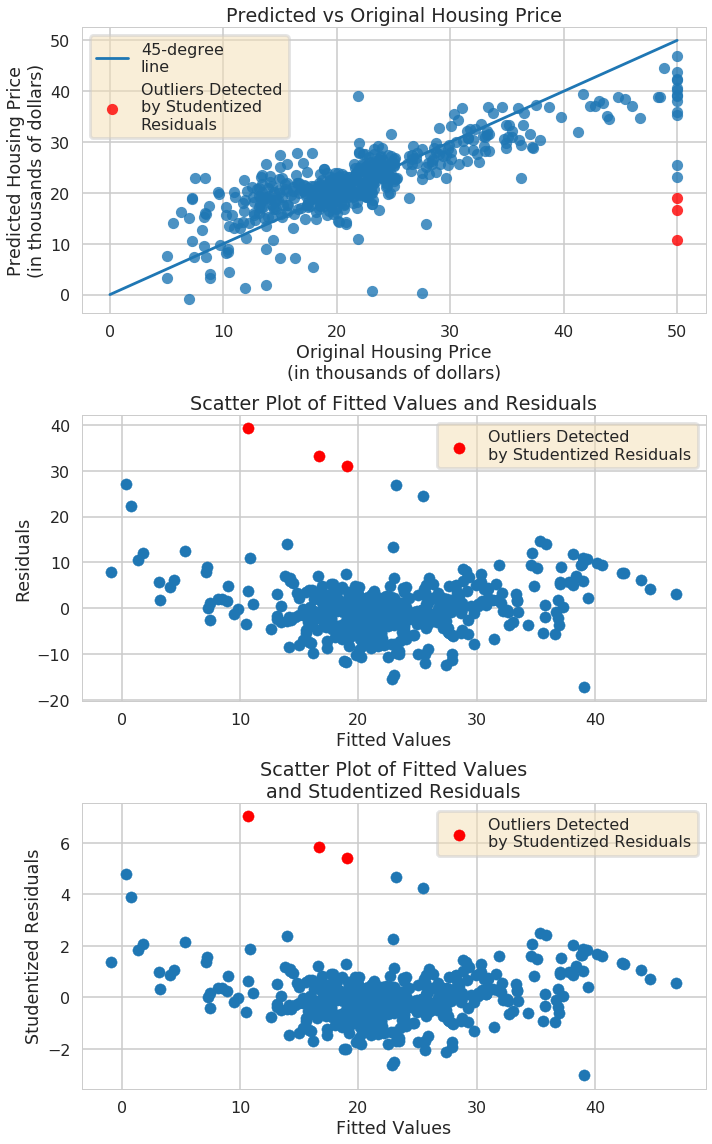

In [60]:
studentized_outliers_idx = m_crim_rm_ptratio_price.fittedvalues.index.isin(studentized_outliers.index)

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 16))

# Scatter plot fitted values vs actual values (studentized outliers)
_ = sns.regplot(y = m_crim_rm_ptratio_price.fittedvalues[studentized_outliers_idx], 
                x = bos.PRICE[studentized_outliers_idx],
                fit_reg = False, 
                ax = ax1,
                color = 'r')
_ = sns.regplot(y = m_crim_rm_ptratio_price.fittedvalues[~studentized_outliers_idx], 
                x = bos.PRICE[~studentized_outliers_idx],
                fit_reg = False, 
                ax = ax1,
                color = '#1f77b4')
_ = ax1.set_ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = ax1.set_xlabel('Original Housing Price\n(in thousands of dollars)')
_ = ax1.set_title('Predicted vs Original Housing Price')
_ = ax1.plot([0, 50], [0, 50]) # 45 degree line
legend = ax1.legend(['45-degree\nline', 'Outliers Detected\nby Studentized\nResiduals'], frameon = True, 
                    facecolor = 'Wheat', framealpha = 0.5)
legend.get_frame().set_linewidth(3)

# scatter plot of residuals and fitted values (studentized outliers)
_ = ax2.scatter(x = m_crim_rm_ptratio_price.fittedvalues[studentized_outliers_idx], 
                  y = m_crim_rm_ptratio_price.resid[studentized_outliers_idx], 
                  color = 'r')
_ = ax2.scatter(x = m_crim_rm_ptratio_price.fittedvalues[~studentized_outliers_idx], 
                  y = m_crim_rm_ptratio_price.resid[~studentized_outliers_idx], 
                  color = '#1f77b4')
_ = ax2.set_xlabel('Fitted Values')
_ = ax2.set_ylabel('Residuals')
_ = ax2.set_title('Scatter Plot of Fitted Values and Residuals')
legend = ax2.legend(['Outliers Detected\nby Studentized Residuals'], frameon = True, facecolor = 'Wheat', framealpha = 0.5)
legend.get_frame().set_linewidth(3)

# scatter plot of studentized residuals and fitted values (studentized outliers)
_ = ax3.scatter(x = m_crim_rm_ptratio_price.fittedvalues[studentized_outliers_idx], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[studentized_outliers_idx], 
                  color = 'r')
_ = ax3.scatter(x = m_crim_rm_ptratio_price.fittedvalues[~studentized_outliers_idx], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[~studentized_outliers_idx],
                  color = '#1f77b4')
_ = ax3.set_xlabel('Fitted Values')
_ = ax3.set_ylabel('Studentized Residuals')
_ = ax3.set_title('Scatter Plot of Fitted Values\nand Studentized Residuals')
legend = ax3.legend(['Outliers Detected\nby Studentized Residuals'], frameon = True, facecolor = 'Wheat', framealpha = 0.5)
legend.get_frame().set_linewidth(3)

fig.tight_layout()
fig.show()

In [61]:
# add fitted values to original data frame
bos['Predicted_Price'] = m_crim_rm_ptratio_price.fittedvalues

# select rows from original data frame for outliers identified by studentized residuals
# select CRIM, RM, PTRATIO columns
wanted_column_idx = [bos.columns.get_loc(c) for c in bos.columns if c in ['CRIM', 'RM', 'PTRATIO', 'PRICE', 'Predicted_Price']]
bos.iloc[studentized_outliers_idx, wanted_column_idx]

,CRIM,RM,PTRATIO,PRICE,Predicted_Price
368,4.89822,4.970,20.2,50.0,10.691218
371,9.23230,6.216,20.2,50.0,19.012691
372,8.26725,5.875,20.2,50.0,16.690622


Based on the studentized distribution and the adjusted Bonferroni p-values, it seems as though there are three potential outliers. Among the three points, it is clear that the predicted values are very different from the actual price of the house. 

What these values might represent:

* The houses with actual housing values of $50,000 might be an error in the data entry. 
* These data points might represent anomalies that the linear model does not pick up.

**5. Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.**

Although it is a rule of thumb that high leverage points follow the following criteria:

$$h_{ii} > 3 \left(\frac{p}{n}\right) = 0.024$$

where 
* $h_{ii}$ is the leverage value, which quantifies the influence that the observed $y_i$ has on the predicted value $\hat{y}_i$
* $p = 4$ is the number of parameters to estimate, including the slope
* $n = 506$ is the sample size

I will instead change the cut off to 0.05 after observing the data and the plots below. The reason for this is because the cut off at 0.024 would generate too many high leverage points. In this model, it seems as though there are many points that have relatively high leverage values. However, there are a select few observations where it's noticeable that their leverage values are pretty large compared to the rest of the points.

In answering this question, I took some functions from statsmodels and tweaked it a little to adjust for the plot size and font size.

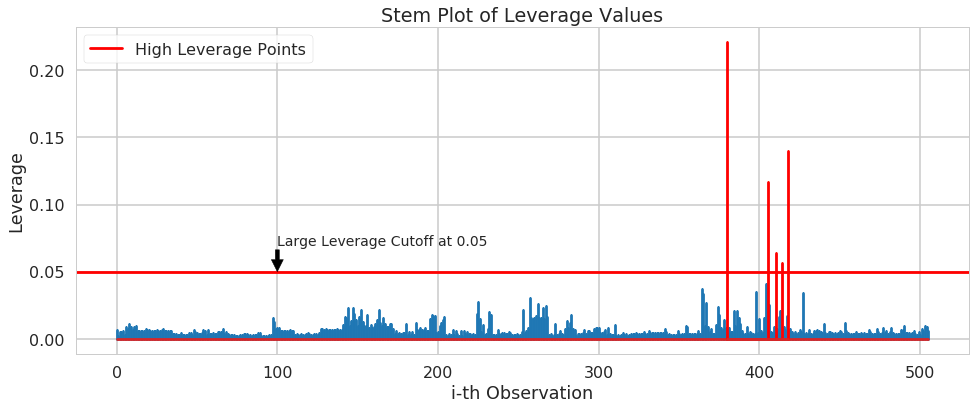

In [62]:
n = len(bos.PRICE)
p = 4
influence = m_crim_rm_ptratio_price.get_influence()
leverage = influence.hat_matrix_diag
large_leverage_cutoff = 0.05
large_leverage = leverage > large_leverage_cutoff

# create dataframe for plotting
leverage_df = pd.DataFrame({'leverage': leverage}).reset_index()
h1 = leverage_df[~large_leverage].index
h2 = leverage_df[large_leverage].index

# create stemplot
_ = plt.figure(figsize = (16, 6))
markerline1, stemlines, _ = plt.stem(h1, leverage[~large_leverage], markerfmt=",")
_ = plt.setp(stemlines, color = '#1f77b4')
markerline2, stemlines, _ = plt.stem(h2, leverage[large_leverage], markerfmt=",")
_ = plt.setp(stemlines, color = 'r')
_ = plt.axhline(y = large_leverage_cutoff, color = 'r')
_ = plt.annotate('Large Leverage Cutoff at {}'.format(round(large_leverage_cutoff, 3)), 
                 xy = (100, large_leverage_cutoff), 
                 xytext = (100, 0.07), 
                 arrowprops = dict(facecolor = 'black'),
                 fontsize = 14)
_ = plt.title('Stem Plot of Leverage Values')
_ = plt.xlabel('i-th Observation')
_ = plt.ylabel('Leverage')
_ = plt.legend(['High Leverage Points'], frameon = True)

plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 16))

# scatter plot of Studentized Residuals and CRIM
_ = ax1.scatter(x = bos.CRIM[large_leverage], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[large_leverage], 
                  color = 'r')
_ = ax1.scatter(x = bos.CRIM[~large_leverage], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[~large_leverage], 
                  color = '#1f77b4')
_ = ax1.set_xlabel('CRIM')
_ = ax1.set_ylabel('Studentized Residuals')
_ = ax1.set_title('Scatter Plot of CRIM and Studentized Residuals')
legend = ax1.legend(['High Leverage Points'], frameon = True, facecolor = 'Wheat', framealpha = 0.5)
legend.get_frame().set_linewidth(3)

for txt in h2:
    ax1.annotate(txt, (bos.CRIM[large_leverage][txt], 
                       m_crim_rm_ptratio_price.outlier_test().student_resid[large_leverage][txt]), fontsize = 15)
    
# scatter plot of Studentized Residuals and RM
_ = ax2.scatter(x = bos.RM[large_leverage], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[large_leverage], 
                  color = 'r')
_ = ax2.scatter(x = bos.RM[~large_leverage], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[~large_leverage], 
                  color = '#1f77b4')
_ = ax2.set_xlabel('RM')
_ = ax2.set_ylabel('Studentized Residuals')
_ = ax2.set_title('Scatter Plot of RM and Studentized Residuals')
legend = ax2.legend(['High Leverage Points'], frameon = True, facecolor = 'Wheat', framealpha = 0.5)
legend.get_frame().set_linewidth(3)

for txt in h2:
    ax2.annotate(txt, (bos.RM[large_leverage][txt], 
                       m_crim_rm_ptratio_price.outlier_test().student_resid[large_leverage][txt]), fontsize = 15)
    
# scatter plot of studentized Studentized Residuals and PTRATIO
_ = ax3.scatter(x = bos.PTRATIO[large_leverage], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[large_leverage], 
                  color = 'r')
_ = ax3.scatter(x = bos.PTRATIO[~large_leverage], 
                  y = m_crim_rm_ptratio_price.outlier_test().student_resid[~large_leverage],
                  color = '#1f77b4')
_ = ax3.set_xlabel('PTRATIO')
_ = ax3.set_ylabel('Studentized Residuals')
_ = ax3.set_title('Scatter Plot of PTRATIO and Studentized Residuals')
legend = ax3.legend(['High Leverage Points'], frameon = True, facecolor = 'Wheat', framealpha = 0.5)
legend.get_frame().set_linewidth(3)

for txt in h2:
    ax3.annotate(txt, (bos.PTRATIO[large_leverage][txt],
                       m_crim_rm_ptratio_price.outlier_test().student_resid[large_leverage][txt]), fontsize = 15)

fig.tight_layout()
fig.show()

In [ ]:
def create_mpl_ax(ax=None):
    """
    Helper function for when a single plot axis is needed.

    Parameters
    ----------
    ax : Matplotlib AxesSubplot instance, optional
        If given, this subplot is used to plot in instead of a new figure being
        created.

    Returns
    -------
    fig : Matplotlib figure instance
        If `ax` is None, the created figure.  Otherwise the figure to which
        `ax` is connected.
    ax : Matplotlib AxesSubplot instance
        The created axis if `ax` is None, otherwise the axis that was passed
        in.

    Notes
    -----
    This function imports `matplotlib.pyplot`, which should only be done to
    create (a) figure(s) with ``plt.figure``.  All other functionality exposed
    by the pyplot module can and should be imported directly from its
    Matplotlib module.

    See Also
    --------
    create_mpl_fig

    Examples
    --------
    A plotting function has a keyword ``ax=None``.  Then calls:

    >>> from statsmodels.graphics import utils
    >>> fig, ax = utils.create_mpl_ax(ax)
    """
    
    if ax is None:
        fig = plt.figure(figsize = (12, 8))
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure

    return fig, ax

from statsmodels.compat.python import lrange, lzip

def _high_leverage(results):
    '''Function that calculates and returns boolean of high leverage points'''    
    return 3. * (results.df_model + 1)/results.nobs

def plot_leverage_resid2(results, alpha=.05, ax=None,
                         **kwargs):

    """
    Plots leverage statistics vs. normalized residuals squared

    Parameters
    ----------
    results : results instance
        A regression results instance
    alpha : float
        Specifies the cut-off for large-standardized residuals. Residuals
        are assumed to be distributed N(0, 1) with alpha=alpha.
    ax : Axes instance
        Matplotlib Axes instance

    Returns
    -------
    fig : matplotlib Figure
        A matplotlib figure instance.
    """
    
    from scipy.stats import zscore, norm

    fig, ax = create_mpl_ax(ax)

    infl = results.get_influence()
    leverage = infl.hat_matrix_diag
    resid = zscore(results.resid)
    ax.plot(resid**2, leverage, 'o', **kwargs)
    ax.set_xlabel("Normalized residuals**2")
    ax.set_ylabel("Leverage")
    ax.set_title("Leverage vs. Normalized residuals squared")

    large_leverage = leverage > _high_leverage(results)
    #norm or t here if standardized?
    cutoff = norm.ppf(1.-alpha/2)
    large_resid = np.abs(resid) > cutoff
    labels = results.model.data.row_labels
    if labels is None:
        labels = lrange(int(results.nobs))
    index = np.where(np.logical_or(large_leverage, large_resid))[0]
    ax = utils.annotate_axes(index, labels, lzip(resid**2, leverage),
                             [(0, 5)]*int(results.nobs), "large",
                             ax=ax, ha="center", va="bottom")
    ax.margins(.075, .075)
    return fig

In [ ]:
_ = plot_leverage_resid2(m_crim_rm_ptratio_price)

In [ ]:
def influence_plot(results, external=True, alpha=.05, criterion="cooks",
                   size=48, plot_alpha=.75, ax=None, **kwargs):
    """
    Plot of influence in regression. Plots studentized resids vs. leverage.

    Parameters
    ----------
    results : results instance
        A fitted model.
    external : bool
        Whether to use externally or internally studentized residuals. It is
        recommended to leave external as True.
    alpha : float
        The alpha value to identify large studentized residuals. Large means
        abs(resid_studentized) > t.ppf(1-alpha/2, dof=results.df_resid)
    criterion : str {'DFFITS', 'Cooks'}
        Which criterion to base the size of the points on. Options are
        DFFITS or Cook's D.
    size : float
        The range of `criterion` is mapped to 10**2 - size**2 in points.
    plot_alpha : float
        The `alpha` of the plotted points.
    ax : matplotlib Axes instance
        An instance of a matplotlib Axes.

    Returns
    -------
    fig : matplotlib figure
        The matplotlib figure that contains the Axes.

    Notes
    -----
    Row labels for the observations in which the leverage, measured by the
    diagonal of the hat matrix, is high or the residuals are large, as the
    combination of large residuals and a high influence value indicates an
    influence point. The value of large residuals can be controlled using the
    `alpha` parameter. Large leverage points are identified as
    hat_i > 2 * (df_model + 1)/nobs.
    """
    fig, ax = create_mpl_ax(ax)

    infl = results.get_influence()

    if criterion.lower().startswith('coo'):
        psize = infl.cooks_distance[0]
    elif criterion.lower().startswith('dff'):
        psize = np.abs(infl.dffits[0])
    else:
        raise ValueError("Criterion %s not understood" % criterion)

    # scale the variables
    #TODO: what is the correct scaling and the assumption here?
    #we want plots to be comparable across different plots
    #so we would need to use the expected distribution of criterion probably
    old_range = np.ptp(psize)
    new_range = size**2 - 8**2

    psize = (psize - psize.min()) * new_range/old_range + 8**2

    leverage = infl.hat_matrix_diag
    if external:
        resids = infl.resid_studentized_external
    else:
        resids = infl.resid_studentized_internal

    from scipy import stats

    cutoff = stats.t.ppf(1.-alpha/2, results.df_resid)
    large_resid = np.abs(resids) > cutoff
    large_leverage = leverage > _high_leverage(results)
    large_points = np.logical_or(large_resid, large_leverage)

    ax.scatter(leverage, resids, s=psize, alpha=plot_alpha)

    # add point labels
    labels = results.model.data.row_labels
    if labels is None:
        labels = lrange(len(resids))
    ax = utils.annotate_axes(np.where(large_points)[0], labels,
                             lzip(leverage, resids),
                             lzip(-(psize/2)**.5, (psize/2)**.5), "large",
                             ax)

    #TODO: make configurable or let people do it ex-post?
    font = {"fontsize" : 16, "color" : "black"}
    ax.set_ylabel("Studentized Residuals", **font)
    ax.set_xlabel("H Leverage", **font)
    ax.set_title("Influence Plot", **font)
    return fig

In [ ]:
_ = influence_plot(m_crim_rm_ptratio_price)

In [ ]:
# add leverage column to data
bos['leverage'] = leverage
# select rows from original data frame for points with large leverage
bos.iloc[large_leverage, wanted_column_idx]

Based on the plots and the dataframe above, I can see that all the high leverage points come from observations that have high crime rates. It is important to note that high leverage points are not influential points. High leverage points are defined as observations in which the predictor values are higher than the rest of the data. This does not necessarily mean that these points would have high influence. To measure influence, I would examine DIFFITS and Cook's Distance values.

**6. Remove the outliers and high leverage points from your model and run the regression again. How do the results change?**

In [ ]:
# remove high leverage points and outliers
bos_no_extreme = bos[~(large_leverage | studentized_outliers_idx)]

# using statsmodels
m_crim_rm_ptratio_price_no_extreme = ols('PRICE ~ CRIM + RM + PTRATIO',bos_no_extreme).fit()
m_crim_rm_ptratio_price_no_extreme.summary()

In [ ]:
# scatter plots for fitted values vs actual values for model with extreme values and model without extreme values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

# model with extreme values
_ = sns.regplot(x = bos.PRICE, y = m_crim_rm_ptratio_price.fittedvalues, fit_reg = False, ax = ax1)
_ = ax1.plot([0, 50], [0, 50], color = 'g')
_ = ax1.set_ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = ax1.set_xlabel('Original Housing Price\n(in thousands of dollars)')
_ = ax1.set_title('Predicted vs Original Housing Price')
_ = ax1.legend(['45-degree\nline'], frameon = True)

# model without extreme values
_ = sns.regplot(x = bos_no_extreme.PRICE, y = m_crim_rm_ptratio_price_no_extreme.fittedvalues, fit_reg = False, ax = ax2)
_ = ax2.plot([0, 50], [0, 50], color = 'g')
_ = ax2.set_ylabel('Predicted Housing Price\n(in thousands of dollars)')
_ = ax2.set_xlabel('Original Housing Price\n(in thousands of dollars)')
_ = ax2.set_title('Predicted vs Original Housing Price\n(Outliers and High Leverage Removed)')
_ = ax2.legend(['45-degree\nline'], frameon = True)

fig.tight_layout()
fig.show()

In [ ]:
# dataframe of estimated coefficients to be used for plotting
coef_df = pd.DataFrame()
labels = ['w/ Outliers\nand\nHigh\nLeverage\nPoints', 'w/o Outliers\nand\nHigh\nLeverage\nPoints']
for i, mod in enumerate([m_crim_rm_ptratio_price, m_crim_rm_ptratio_price_no_extreme]):
    err_series = mod.params - mod.conf_int()[0]
    coef_df = coef_df.append(pd.DataFrame({'coef': mod.params.values[1:],
                                           'err': err_series.values[1:],
                                           'varname': err_series.index.values[1:],
                                           'model': labels[i]}))

# dataframe of rsquared and adj rsquared values to be used for plotting
rsquared_df = pd.DataFrame({'rsquared': [m_crim_rm_ptratio_price.rsquared, 
                                         m_crim_rm_ptratio_price_no_extreme.rsquared],
                            'rsquared_adj': [m_crim_rm_ptratio_price.rsquared_adj, 
                                             m_crim_rm_ptratio_price_no_extreme.rsquared_adj],
                            'model': labels[i]})
rsquared_df

## marker to use
marker_list = 'so'
width=0.25
## 5 covariates in total
base_x = pd.np.arange(3) - 0.2

# plot to compare coefficients and rsquared/adj rsquared for model with extreme values and model without extreme values
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))

# plot of coefficient comparison btwn model w/ extreme values and model w/o extreme values
for i, mod in enumerate(coef_df.model.unique()):
    mod_df = coef_df[coef_df.model == mod]
    mod_df = mod_df.set_index('varname').reindex(coef_df['varname'].unique())
    ## offset x posistions
    X = base_x + width*i
    ax1.bar(X, mod_df['coef'],  
           color='none',yerr=mod_df['err'])
    ## remove ax1is labels
    ax1.set_ylabel('Coefficient Values')
    ax1.set_xlabel('')
    ax1.set_title('Comparison of Coefficient Estimates')
    ax1.scatter(x=X, 
               marker=marker_list[i], s=120, 
               y=mod_df['coef'], color='black')
    ax1.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax1.xaxis.set_ticks_position('none')
    _ = ax1.set_xticklabels(['', '', 'CRIM     ','', 'RM     ', '', 'PTRATIO     '], 
                           rotation=0, fontsize=16)

    fs = 16
    
# build customized legend
legend_elements = [Line2D([0], [0], marker=m,
                          label=labels[i],
                          color = 'k',
                          markersize=10)
                   for i, m in enumerate(marker_list)
                  ]
_ = ax1.legend(handles=legend_elements, loc=2, 
              prop={'size': 15}, labelspacing=1.2)

# bar plot to compare rsquared and adj rsquared values for model w/ extreme values and model w/o extreme values
_ = rsquared_df.plot(x = 'model', y = rsquared_df.columns[:-1], kind = 'bar', ax = ax2)
_ = ax2.set_title('Comparison of R-Squared\nand Adjusted R-Squared')
_ = ax2.legend(['R-Squared', 'Adjusted R-Squared'], loc = 'upper left')
_ = ax2.set_xlabel('Model')
_ = ax2.set_xticklabels(labels = labels, rotation = 0)

fig.tight_layout()
fig.show()

Based on the plots and the summary outputs of the linear model, we can see that the R-squared and the adjusted R-squared values for the model without outliers and high leverage points are higher. This suggests that the model without the high leverage values and outliers fit the data better.

We also see that the coefficient values for the two models are similar.